# This notebook generates difference statistics for our SMAP rSIR paper



In [1]:
%pylab notebook
from cetbtools.ease2conv import Ease2Transform
import glob
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np
import pdb
import scipy.ndimage

Populating the interactive namespace from numpy and matplotlib


The subset region we are using in Fig. 13 for the paper is bounded in the EASE2_N projection by:

<ul>
    <li>UL lat:  28.196</li>
    <li>UL lon: -97.085 </li>
    <li>LR lat:  47.785 </li>
    <li>LR lon: -75.595</li>
</ul>    

Which correspond to EASE2_N3.125 coordinates of


In [2]:
ULlat = 28.196
ULlon = -97.085
LRlat = 47.785
LRlon = -75.595
N3grid = Ease2Transform("EASE2_N3.125km")
(ULrow, ULcol) = N3grid.geographic_to_grid(ULlat, ULlon)
print("UL:", ULrow, ULcol)
ULrow = int(round(ULrow))
ULcol = int(round(ULcol))
print("UL:", ULrow, ULcol)
(LRrow, LRcol) = N3grid.geographic_to_grid(LRlat, LRlon)
print("LR:", LRrow, LRcol)
LRrow = int(round(LRrow))
LRcol = int(round(LRcol))
print("LR:", LRrow, LRcol)

UL: 2620.8135058929192 798.1984423315253
UL: 2621 798
LR: 3245.8460861653134 1453.192942063034
LR: 3246 1453


In [3]:
N25grid = Ease2Transform("EASE2_N25km")
(ULrow25, ULcol25) = N25grid.geographic_to_grid(ULlat, ULlon)
ULrow25 = int(round(ULrow25))
ULcol25 = int(round(ULcol25))
print("UL 25:", ULrow25, ULcol25)
(LRrow25, LRcol25) = N25grid.geographic_to_grid(LRlat, LRlon)
LRrow25 = int(round(LRrow25))
LRcol25 = int(round(LRcol25))
print("LR 25:", LRrow25, LRcol25)

UL 25: 327 99
LR 25: 405 181


In [4]:
# read the 3.125 km loci mask
def read_loci():
    locifile = "/share/data/LandCover/gridded/EASE2_N3.125km.LOCImask_land50_coast0km.5760x5760.bin"
    f = open(locifile, "r")
    loci = np.fromfile(f, dtype=np.uint8)
    loci = np.reshape(loci, (5760, 5760))
    f.close()
    return loci

In [5]:
def show_loci(loci):
    fig, ax = plt.subplots(1)
    im = ax.imshow(loci, cmap=plt.cm.gray, vmin=np.min(loci), vmax=np.max(loci))
    ax.axis('off')
    fig.colorbar(im, ax=ax)
    fig.tight_layout()    

In [6]:
# Read the file and resize to 3km if it's not already
def read_file_for_3km_data(file):
    f = Dataset(file, 'r', "NETCDF4")
    data = np.squeeze(f.variables['TB'][:])
    print("grid: %s" % f.variables['crs'].long_name)
    if ("EASE2_N25km" == f.variables['crs'].long_name):
        print("resizing to 3.125 km grid...")
        factor = 8
        data = scipy.ndimage.zoom(data, factor, order=0)
    elif ("EASE2_N3.125km" == f.variables['crs'].long_name):
        print("data are already 3.125 km...")
    else:
        raise TypeError("ERROR: unrecognized grid = %s" % f.variables['crs'].long_name)
        
    # Dump the TB attributes
    for k in f.variables['TB'].ncattrs():
        if 'sir_number_of_iterations' == k:
            print("rSIR file: %s" % file)
            print("rSIR data: %s:" % k, getattr(f.variables['TB'], k))
            
    f.close() 
    
    return data

In [7]:
def make_diff(big_lotb, hitb, loci):
    diff = hitb - big_lotb
    diff[big_lotb == 0] = 600.
    diff[loci == 255] = 600.
    return diff

In [8]:
def show_diff(big_lotb, hitb, diff, label1, label2):
    
    fig, ax = plt.subplots(2,2, figsize=(8,6))

    diff_cmap = plt.get_cmap('PiYG')

    ax[0,0].axis('off')

    im10 = ax[1,0].imshow(big_lotb, cmap=plt.cm.gray, vmin=np.min(big_lotb), vmax=np.max(big_lotb))
    ax[1,0].set_title(label1)
    ax[1,0].axis('off')
    fig.colorbar(im10, ax=ax[1,0])

    im01 = ax[0,1].imshow(hitb, cmap=plt.cm.gray, vmin=np.min(hitb), vmax=np.max(hitb))
    ax[0,1].set_title(label2)
    ax[0,1].axis('off')
    fig.colorbar(im01, ax=ax[0,1])

    # extreme = np.max([abs(np.min(diff)), np.max(diff[diff < 600.])])
    extreme = 10.
    im11 = ax[1,1].imshow(diff, cmap=diff_cmap, 
                          vmin= -1 * extreme,
                          vmax=extreme)
    ax[1,1].set_title("%s - %s" % (label2, label1))
    ax[1,1].axis('off')
    fig.colorbar(im11, ax=ax[1,1])

    fig.tight_layout()

In [9]:
def run_stats(file1, file2, label1, label2):
    
    tb1 = read_file_for_3km_data(file1)
    tb2 = read_file_for_3km_data(file2)

    loci = read_loci()
    diff = make_diff(tb1, tb2, loci)
    
    print("Diff range: %.3f, %.3f" % (np.amin(diff), np.amax(diff[diff < 600.])))
    
    # Subset for region of interest
    subdiff = diff[ULrow:LRrow, ULcol:LRcol]
    subdiff[subdiff==600.] = numpy.nan
    
    subtb1 = tb1[ULrow:LRrow, ULcol:LRcol]
    subtb2 = tb2[ULrow:LRrow, ULcol:LRcol]
    
    show_diff(subtb1, subtb2, subdiff, label1, label2)
    
    diff_mean = np.nanmean(subdiff)
    diff_std = np.nanstd(subdiff)
    
    print("%s: %s" % (label1, file1))
    print("%s: %s" % (label2, file2))
    print("Midwest diff = %s - %s mean: %.3f" % (label2, label1, diff_mean))
    print("Midwest diff = %s - %s  std: %.3f" % (label2, label1, diff_std))
    
    return {"label": "%s-%s" % (label2, label1),
            "mean": diff_mean, 
            "std": diff_std}
    

In [10]:
dibfile = "/Users/brodzik/cetb_data/SMAP_grd/2015/NSIDC-0738-EASE2_N25km-SMAP_LRM-2015092-1.4V-M-GRD-JPL-v0.3.nc"
avefile = "/Users/brodzik/cetb_data/SMAP_sir_nint1/2015/NSIDC-0738-EASE2_N3.125km-SMAP_LRM-2015092-1.4V-M-SIR-JPL-v0.3.nc"
sirfile = "/Users/brodzik/cetb_data/SMAP_sir/2015/NSIDC-0738-EASE2_N3.125km-SMAP_LRM-2015092-1.4V-M-SIR-JPL-v0.3.nc"
bgifile = "/Users/brodzik/cetb_data/SMAP_bgi/2015/NSIDC-0738-EASE2_N3.125km-SMAP_LRM-2015092-1.4V-M-BGI-JPL-v0.3.nc"

In [11]:
file1 = [{"file":dibfile, "label":"DIB"}, 
         {"file":dibfile, "label":"DIB"},
         {"file":dibfile, "label":"DIB"},
         {"file":avefile, "label":"AVE"},
         {"file":avefile, "label":"AVE"},
         {"file":sirfile, "label":"rSIR"}]

file2 = [{"file":avefile, "label":"AVE"},
         {"file":sirfile, "label":"rSIR"},
         {"file":bgifile, "label":"BGI"},
         {"file":sirfile, "label":"rSIR"},
         {"file":bgifile, "label":"BGI"},
         {"file":bgifile, "label":"BGI"}]

f1: %s %s /Users/brodzik/cetb_data/SMAP_grd/2015/NSIDC-0738-EASE2_N25km-SMAP_LRM-2015092-1.4V-M-GRD-JPL-v0.3.nc DIB
f2: %s %s /Users/brodzik/cetb_data/SMAP_sir_nint1/2015/NSIDC-0738-EASE2_N3.125km-SMAP_LRM-2015092-1.4V-M-SIR-JPL-v0.3.nc AVE
grid: EASE2_N25km
resizing to 3.125 km grid...
grid: EASE2_N3.125km
data are already 3.125 km...
rSIR file: /Users/brodzik/cetb_data/SMAP_sir_nint1/2015/NSIDC-0738-EASE2_N3.125km-SMAP_LRM-2015092-1.4V-M-SIR-JPL-v0.3.nc
rSIR data: sir_number_of_iterations: 1
Diff range: -122.060, 129.930


<IPython.core.display.Javascript object>


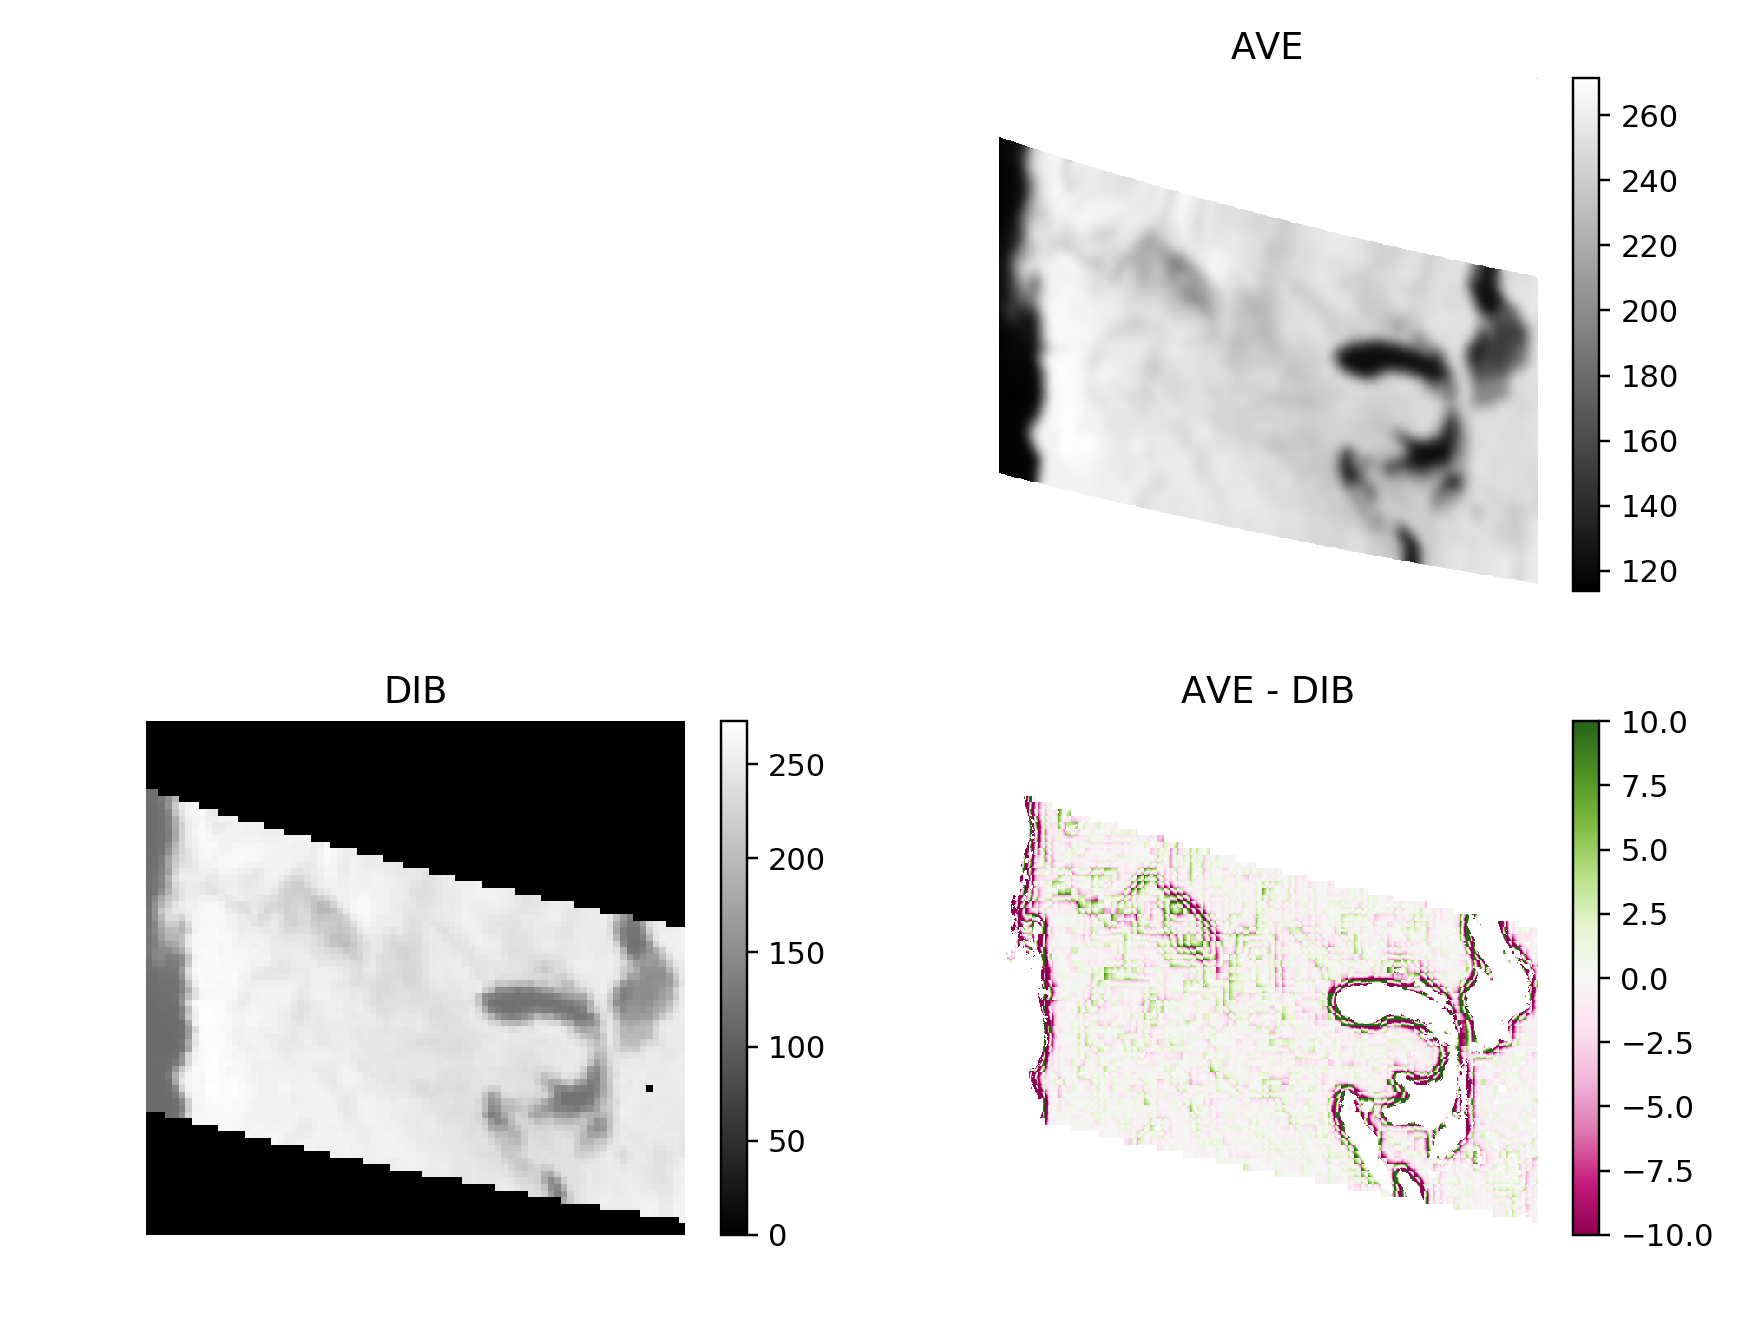

DIB: /Users/brodzik/cetb_data/SMAP_grd/2015/NSIDC-0738-EASE2_N25km-SMAP_LRM-2015092-1.4V-M-GRD-JPL-v0.3.nc
AVE: /Users/brodzik/cetb_data/SMAP_sir_nint1/2015/NSIDC-0738-EASE2_N3.125km-SMAP_LRM-2015092-1.4V-M-SIR-JPL-v0.3.nc
Midwest diff = AVE - DIB mean: -0.311
Midwest diff = AVE - DIB  std: 4.308
this_out {'label': 'AVE-DIB', 'mean': -0.31065652, 'std': 4.307687}
out [{'label': 'AVE-DIB', 'mean': -0.31065652, 'std': 4.307687}]

f1: %s %s /Users/brodzik/cetb_data/SMAP_grd/2015/NSIDC-0738-EASE2_N25km-SMAP_LRM-2015092-1.4V-M-GRD-JPL-v0.3.nc DIB
f2: %s %s /Users/brodzik/cetb_data/SMAP_sir/2015/NSIDC-0738-EASE2_N3.125km-SMAP_LRM-2015092-1.4V-M-SIR-JPL-v0.3.nc rSIR
grid: EASE2_N25km
resizing to 3.125 km grid...
grid: EASE2_N3.125km
data are already 3.125 km...
rSIR file: /Users/brodzik/cetb_data/SMAP_sir/2015/NSIDC-0738-EASE2_N3.125km-SMAP_LRM-2015092-1.4V-M-SIR-JPL-v0.3.nc
rSIR data: sir_number_of_iterations: 25
Diff range: -113.300, 179.130


<IPython.core.display.Javascript object>


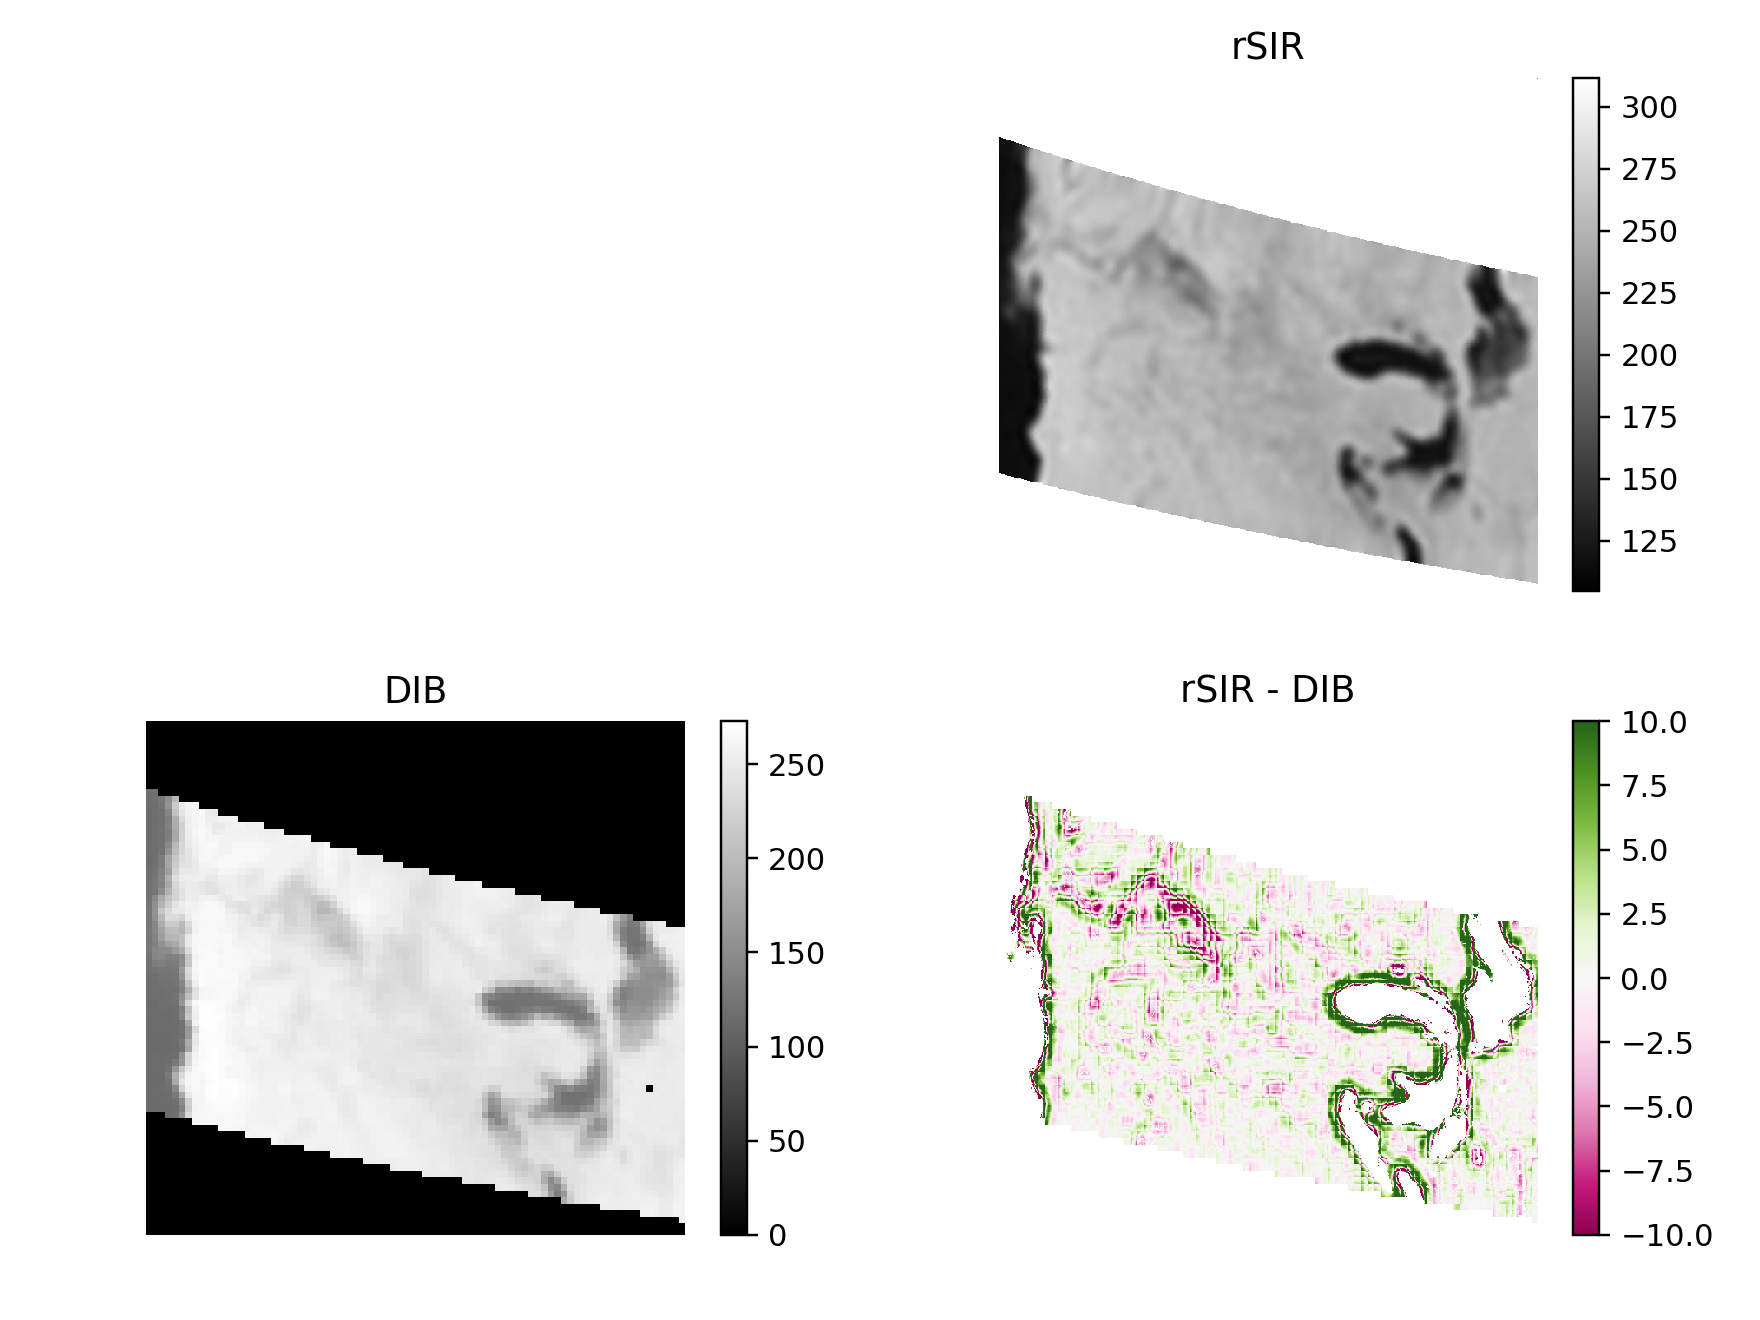

DIB: /Users/brodzik/cetb_data/SMAP_grd/2015/NSIDC-0738-EASE2_N25km-SMAP_LRM-2015092-1.4V-M-GRD-JPL-v0.3.nc
rSIR: /Users/brodzik/cetb_data/SMAP_sir/2015/NSIDC-0738-EASE2_N3.125km-SMAP_LRM-2015092-1.4V-M-SIR-JPL-v0.3.nc
Midwest diff = rSIR - DIB mean: 0.837
Midwest diff = rSIR - DIB  std: 5.346
this_out {'label': 'rSIR-DIB', 'mean': 0.8374889, 'std': 5.345821}
out [{'label': 'AVE-DIB', 'mean': -0.31065652, 'std': 4.307687}, {'label': 'rSIR-DIB', 'mean': 0.8374889, 'std': 5.345821}]

f1: %s %s /Users/brodzik/cetb_data/SMAP_grd/2015/NSIDC-0738-EASE2_N25km-SMAP_LRM-2015092-1.4V-M-GRD-JPL-v0.3.nc DIB
f2: %s %s /Users/brodzik/cetb_data/SMAP_bgi/2015/NSIDC-0738-EASE2_N3.125km-SMAP_LRM-2015092-1.4V-M-BGI-JPL-v0.3.nc BGI
grid: EASE2_N25km
resizing to 3.125 km grid...
grid: EASE2_N3.125km
data are already 3.125 km...
Diff range: -122.060, 118.950


<IPython.core.display.Javascript object>


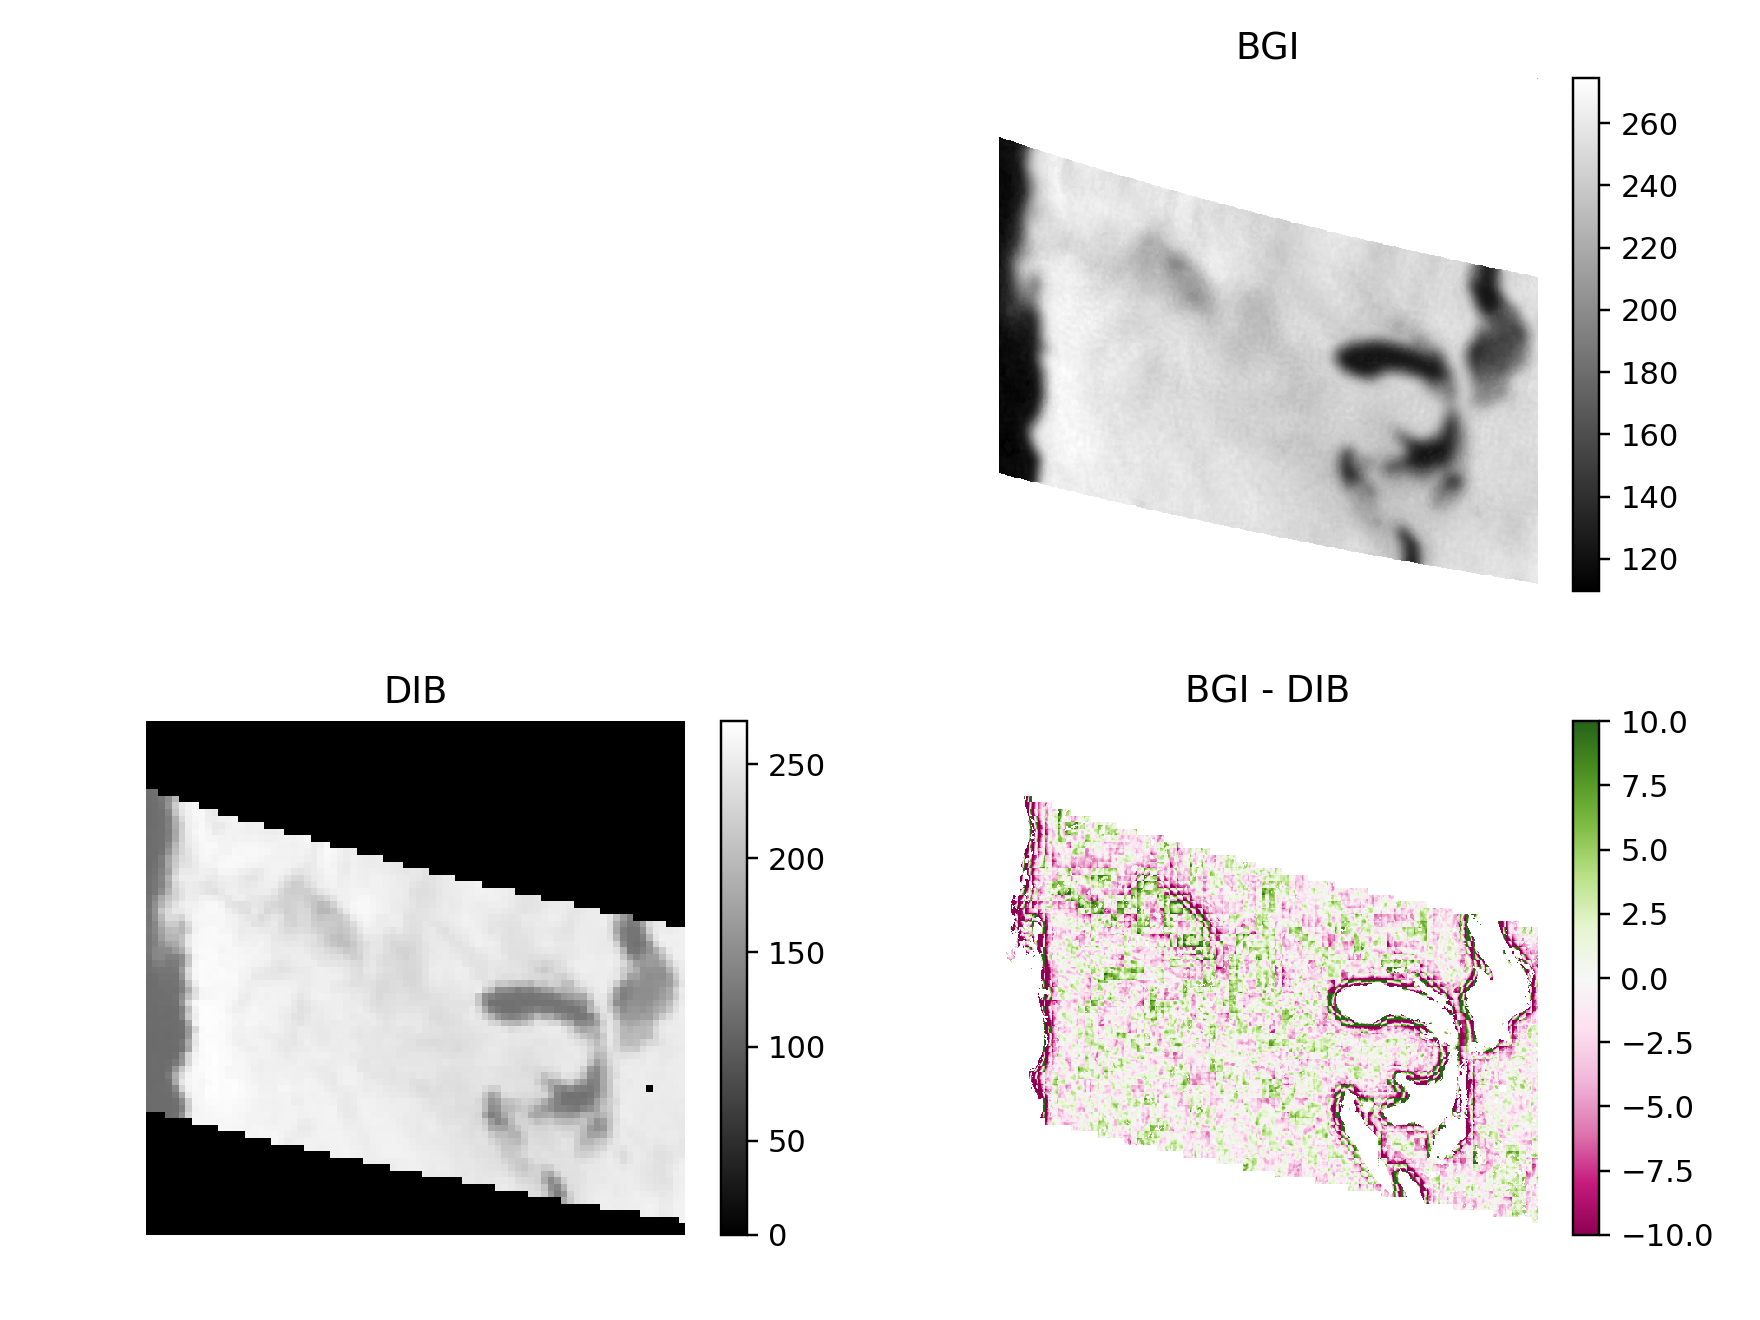

DIB: /Users/brodzik/cetb_data/SMAP_grd/2015/NSIDC-0738-EASE2_N25km-SMAP_LRM-2015092-1.4V-M-GRD-JPL-v0.3.nc
BGI: /Users/brodzik/cetb_data/SMAP_bgi/2015/NSIDC-0738-EASE2_N3.125km-SMAP_LRM-2015092-1.4V-M-BGI-JPL-v0.3.nc
Midwest diff = BGI - DIB mean: -0.553
Midwest diff = BGI - DIB  std: 4.869
this_out {'label': 'BGI-DIB', 'mean': -0.55270463, 'std': 4.8685303}
out [{'label': 'AVE-DIB', 'mean': -0.31065652, 'std': 4.307687}, {'label': 'rSIR-DIB', 'mean': 0.8374889, 'std': 5.345821}, {'label': 'BGI-DIB', 'mean': -0.55270463, 'std': 4.8685303}]

f1: %s %s /Users/brodzik/cetb_data/SMAP_sir_nint1/2015/NSIDC-0738-EASE2_N3.125km-SMAP_LRM-2015092-1.4V-M-SIR-JPL-v0.3.nc AVE
f2: %s %s /Users/brodzik/cetb_data/SMAP_sir/2015/NSIDC-0738-EASE2_N3.125km-SMAP_LRM-2015092-1.4V-M-SIR-JPL-v0.3.nc rSIR
grid: EASE2_N3.125km
data are already 3.125 km...
rSIR file: /Users/brodzik/cetb_data/SMAP_sir_nint1/2015/NSIDC-0738-EASE2_N3.125km-SMAP_LRM-2015092-1.4V-M-SIR-JPL-v0.3.nc
rSIR data: sir_number_of_iterations:

<IPython.core.display.Javascript object>


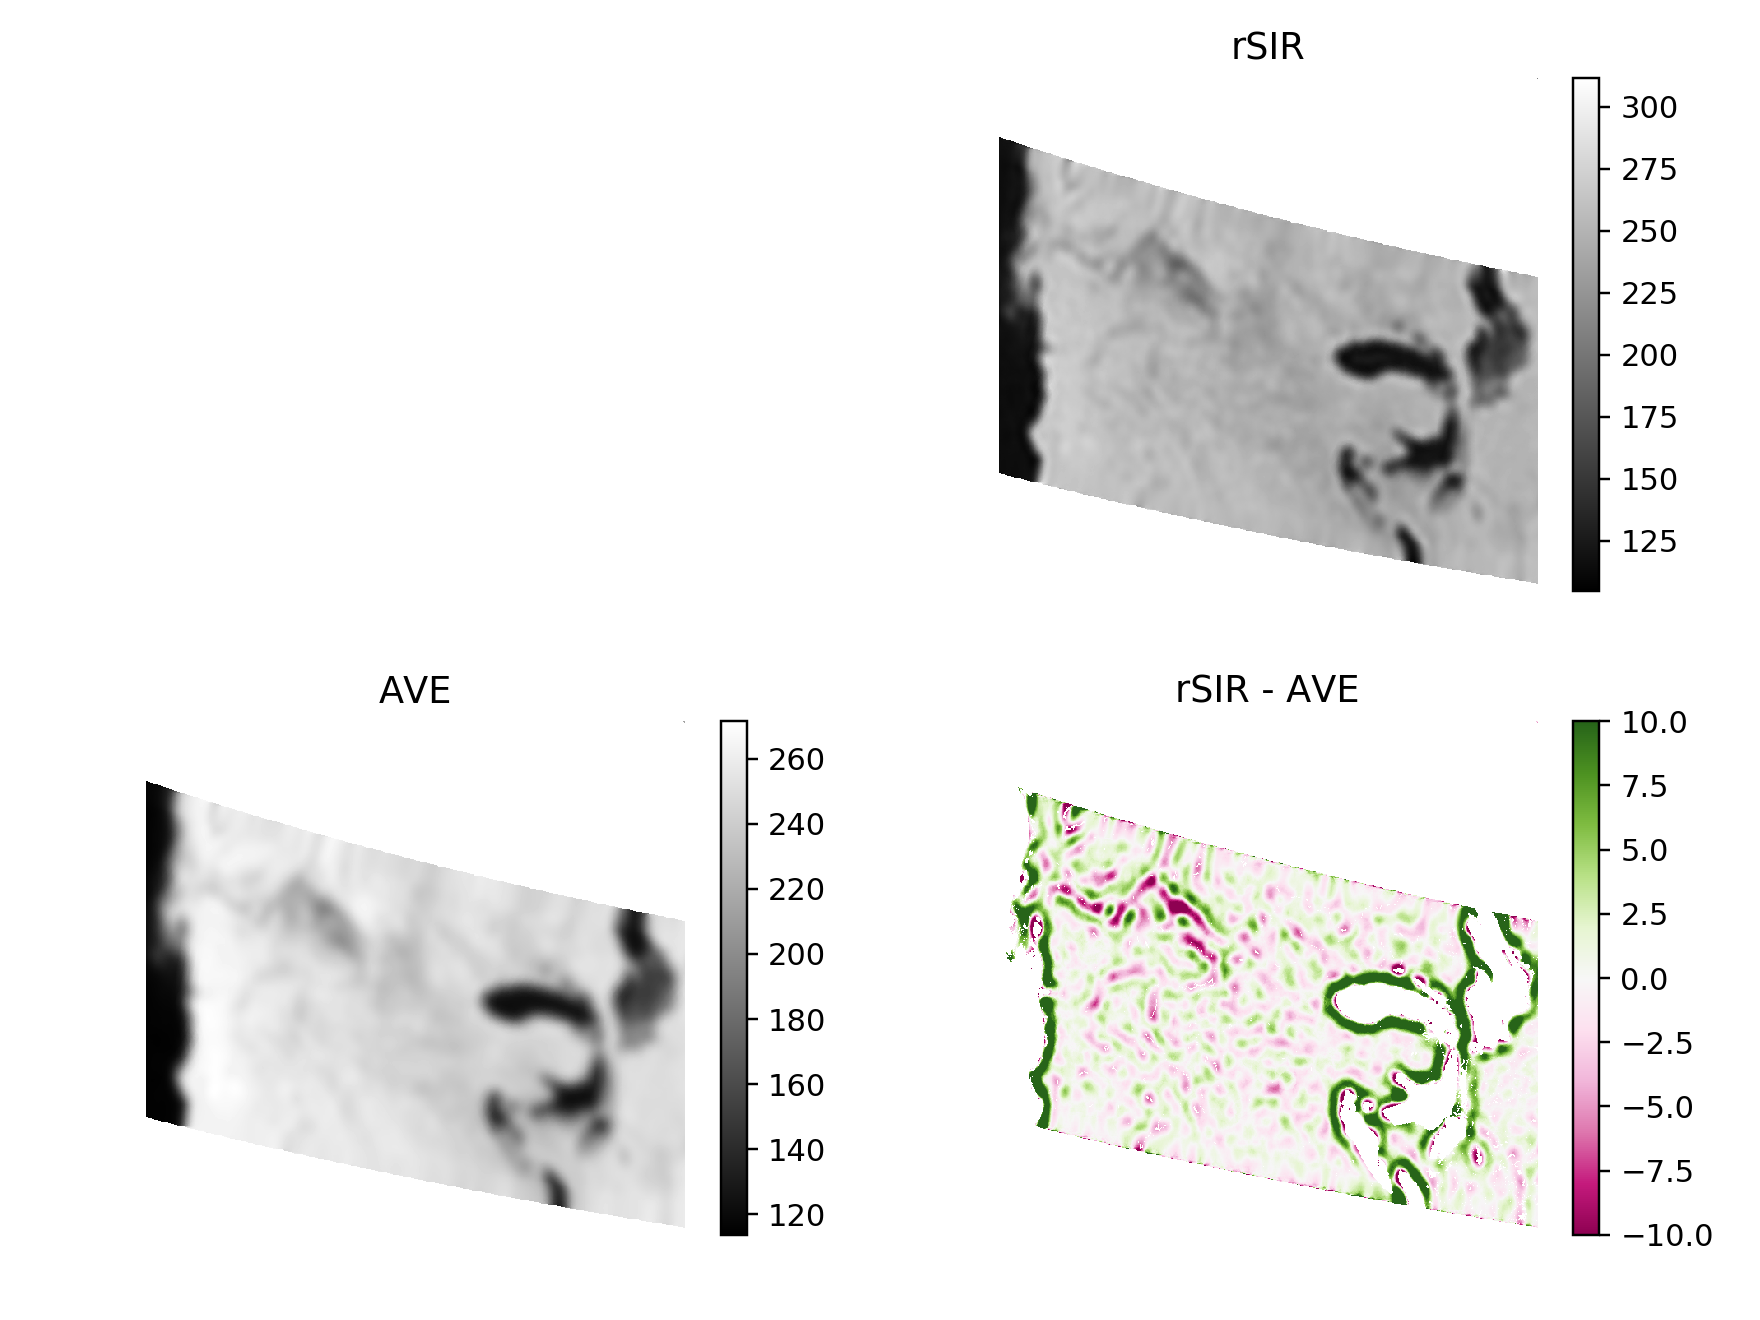

AVE: /Users/brodzik/cetb_data/SMAP_sir_nint1/2015/NSIDC-0738-EASE2_N3.125km-SMAP_LRM-2015092-1.4V-M-SIR-JPL-v0.3.nc
rSIR: /Users/brodzik/cetb_data/SMAP_sir/2015/NSIDC-0738-EASE2_N3.125km-SMAP_LRM-2015092-1.4V-M-SIR-JPL-v0.3.nc
Midwest diff = rSIR - AVE mean: 1.165
Midwest diff = rSIR - AVE  std: 4.576
this_out {'label': 'rSIR-AVE', 'mean': 1.165409, 'std': 4.575833}
out [{'label': 'AVE-DIB', 'mean': -0.31065652, 'std': 4.307687}, {'label': 'rSIR-DIB', 'mean': 0.8374889, 'std': 5.345821}, {'label': 'BGI-DIB', 'mean': -0.55270463, 'std': 4.8685303}, {'label': 'rSIR-AVE', 'mean': 1.165409, 'std': 4.575833}]

f1: %s %s /Users/brodzik/cetb_data/SMAP_sir_nint1/2015/NSIDC-0738-EASE2_N3.125km-SMAP_LRM-2015092-1.4V-M-SIR-JPL-v0.3.nc AVE
f2: %s %s /Users/brodzik/cetb_data/SMAP_bgi/2015/NSIDC-0738-EASE2_N3.125km-SMAP_LRM-2015092-1.4V-M-BGI-JPL-v0.3.nc BGI
grid: EASE2_N3.125km
data are already 3.125 km...
rSIR file: /Users/brodzik/cetb_data/SMAP_sir_nint1/2015/NSIDC-0738-EASE2_N3.125km-SMAP_LRM-20

<IPython.core.display.Javascript object>


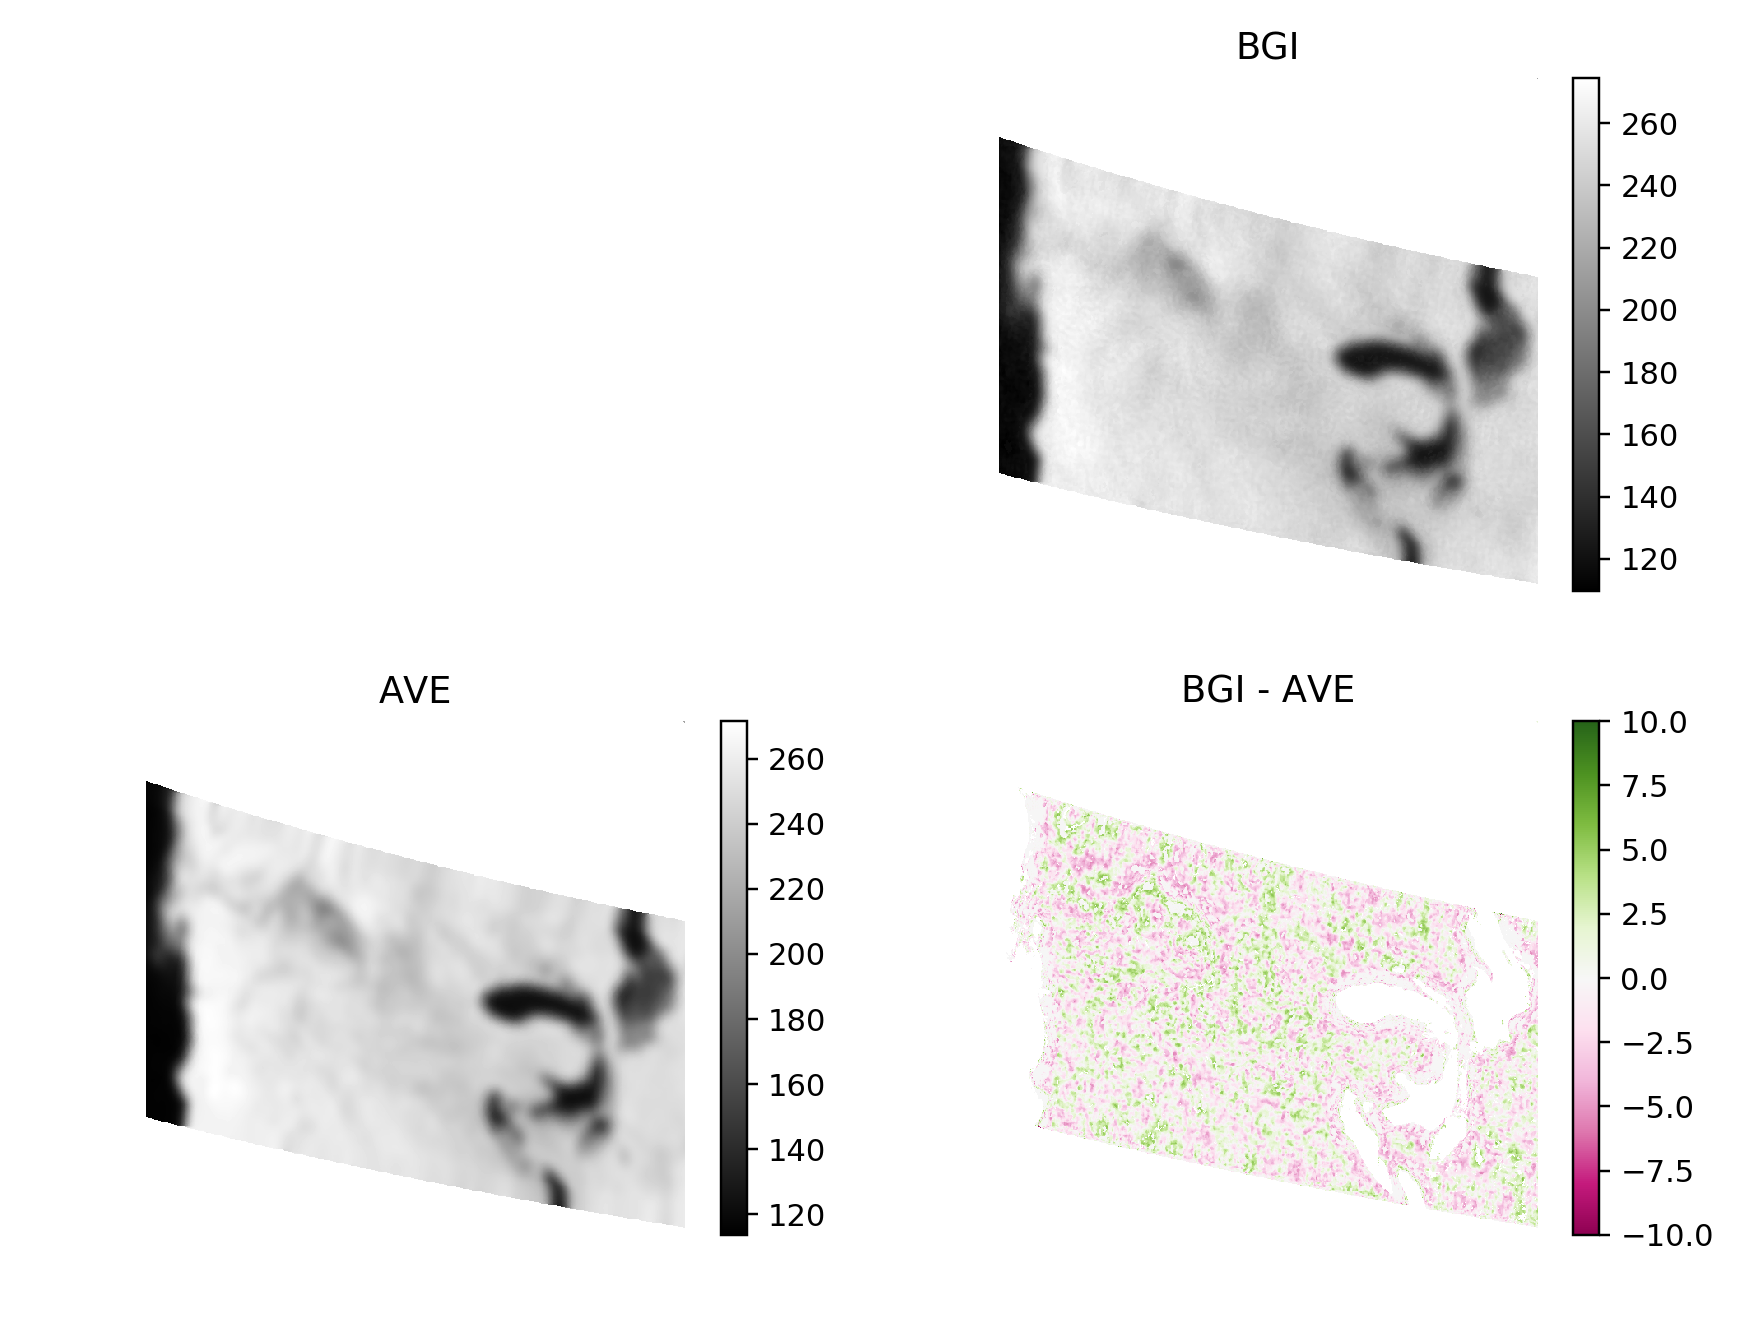

AVE: /Users/brodzik/cetb_data/SMAP_sir_nint1/2015/NSIDC-0738-EASE2_N3.125km-SMAP_LRM-2015092-1.4V-M-SIR-JPL-v0.3.nc
BGI: /Users/brodzik/cetb_data/SMAP_bgi/2015/NSIDC-0738-EASE2_N3.125km-SMAP_LRM-2015092-1.4V-M-BGI-JPL-v0.3.nc
Midwest diff = BGI - AVE mean: -0.239
Midwest diff = BGI - AVE  std: 2.029
this_out {'label': 'BGI-AVE', 'mean': -0.2390817, 'std': 2.0293007}
out [{'label': 'AVE-DIB', 'mean': -0.31065652, 'std': 4.307687}, {'label': 'rSIR-DIB', 'mean': 0.8374889, 'std': 5.345821}, {'label': 'BGI-DIB', 'mean': -0.55270463, 'std': 4.8685303}, {'label': 'rSIR-AVE', 'mean': 1.165409, 'std': 4.575833}, {'label': 'BGI-AVE', 'mean': -0.2390817, 'std': 2.0293007}]

f1: %s %s /Users/brodzik/cetb_data/SMAP_sir/2015/NSIDC-0738-EASE2_N3.125km-SMAP_LRM-2015092-1.4V-M-SIR-JPL-v0.3.nc rSIR
f2: %s %s /Users/brodzik/cetb_data/SMAP_bgi/2015/NSIDC-0738-EASE2_N3.125km-SMAP_LRM-2015092-1.4V-M-BGI-JPL-v0.3.nc BGI
grid: EASE2_N3.125km
data are already 3.125 km...
rSIR file: /Users/brodzik/cetb_data/SM

<IPython.core.display.Javascript object>


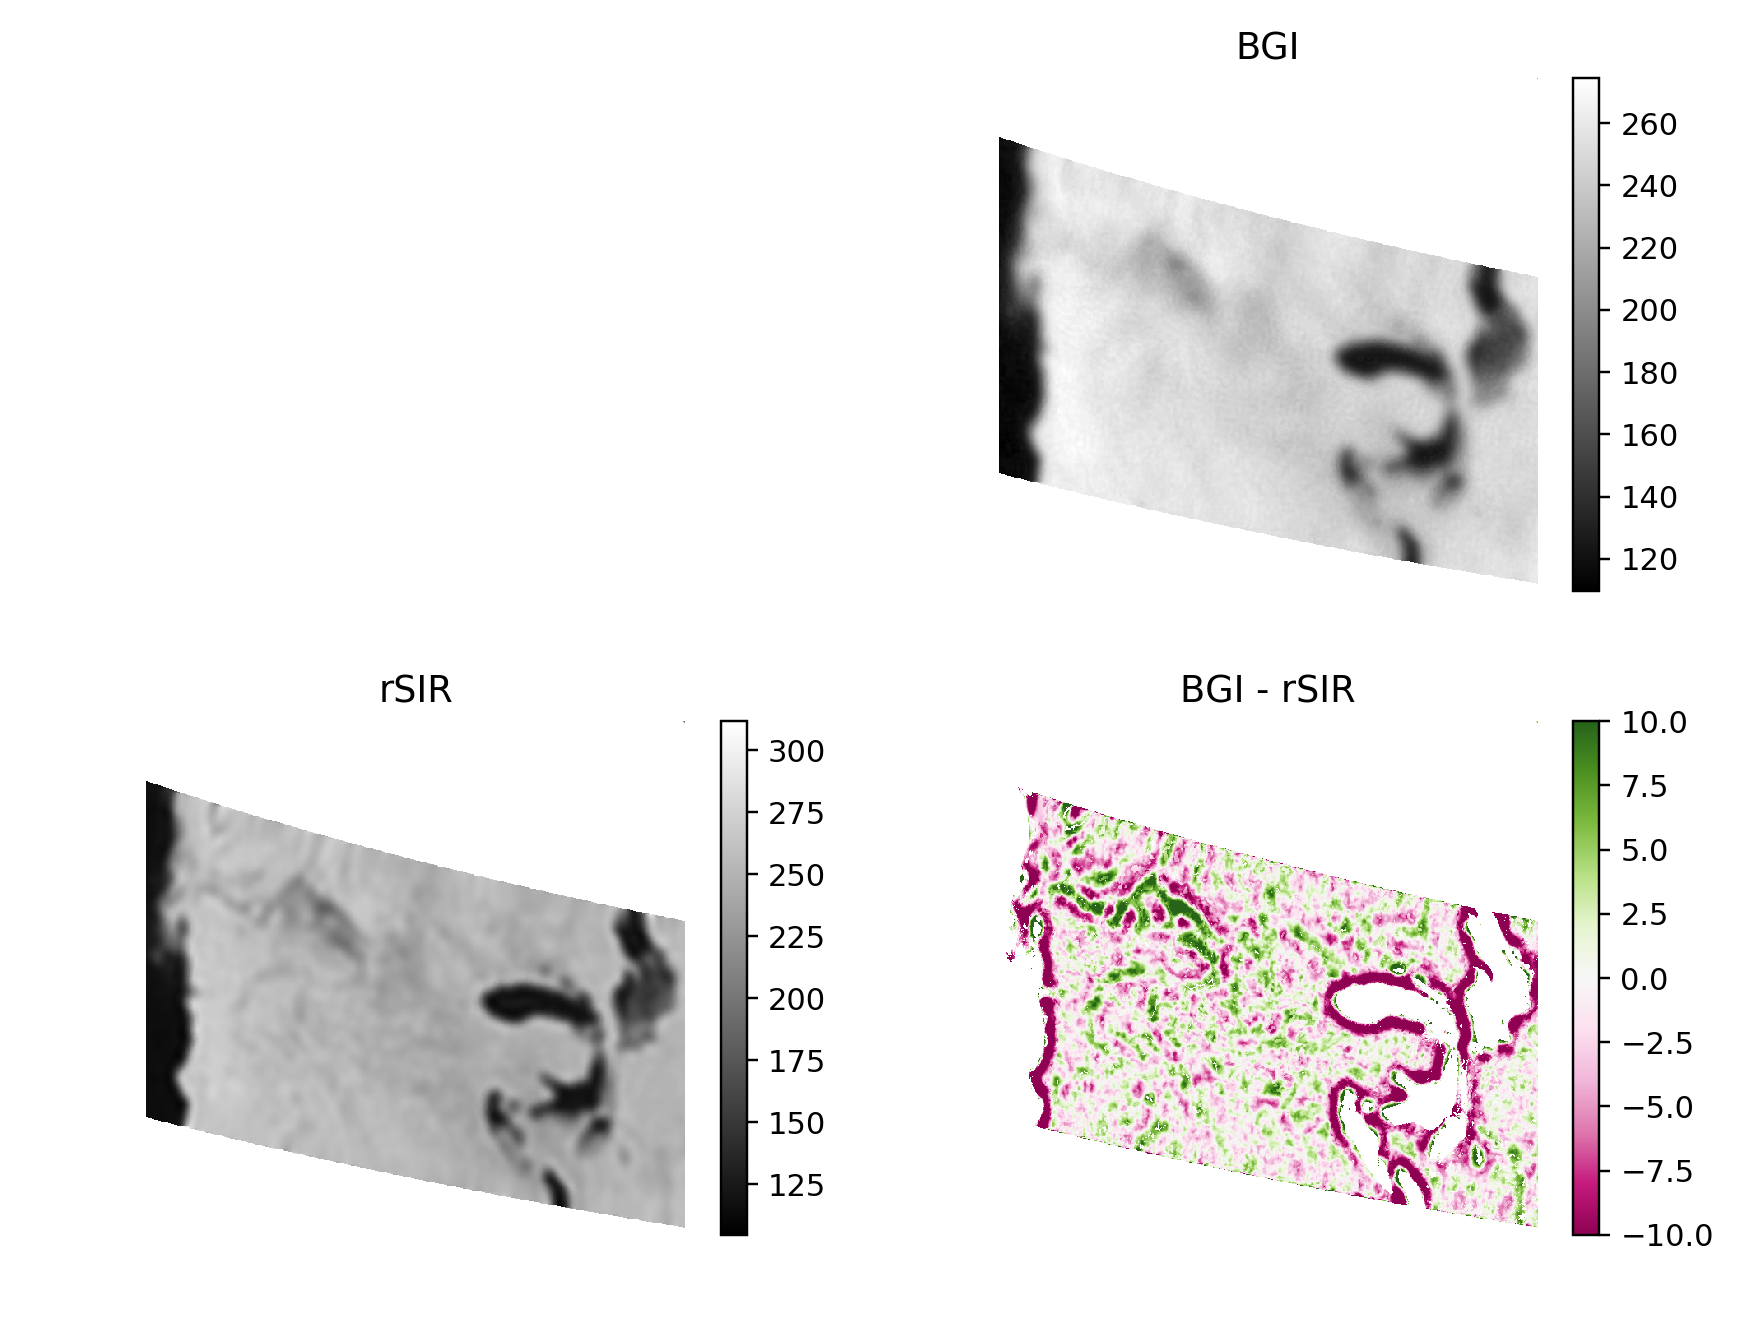

rSIR: /Users/brodzik/cetb_data/SMAP_sir/2015/NSIDC-0738-EASE2_N3.125km-SMAP_LRM-2015092-1.4V-M-SIR-JPL-v0.3.nc
BGI: /Users/brodzik/cetb_data/SMAP_bgi/2015/NSIDC-0738-EASE2_N3.125km-SMAP_LRM-2015092-1.4V-M-BGI-JPL-v0.3.nc
Midwest diff = BGI - rSIR mean: -1.404
Midwest diff = BGI - rSIR  std: 5.469
this_out {'label': 'BGI-rSIR', 'mean': -1.4044906, 'std': 5.4685097}
out [{'label': 'AVE-DIB', 'mean': -0.31065652, 'std': 4.307687}, {'label': 'rSIR-DIB', 'mean': 0.8374889, 'std': 5.345821}, {'label': 'BGI-DIB', 'mean': -0.55270463, 'std': 4.8685303}, {'label': 'rSIR-AVE', 'mean': 1.165409, 'std': 4.575833}, {'label': 'BGI-AVE', 'mean': -0.2390817, 'std': 2.0293007}, {'label': 'BGI-rSIR', 'mean': -1.4044906, 'std': 5.4685097}]



In [12]:
out = []
for f1, f2 in zip(file1, file2):
    print("f1: %s %s", f1["file"], f1["label"])
    print("f2: %s %s", f2["file"], f2["label"])
    this_out = run_stats(f1["file"], f2["file"],
                         f1["label"], f2["label"])
    print("this_out", this_out)
    out.append(this_out)
    print("out", out)
    
    print("")

In [13]:
out

[{'label': 'AVE-DIB', 'mean': -0.31065652, 'std': 4.307687},
 {'label': 'rSIR-DIB', 'mean': 0.8374889, 'std': 5.345821},
 {'label': 'BGI-DIB', 'mean': -0.55270463, 'std': 4.8685303},
 {'label': 'rSIR-AVE', 'mean': 1.165409, 'std': 4.575833},
 {'label': 'BGI-AVE', 'mean': -0.2390817, 'std': 2.0293007},
 {'label': 'BGI-rSIR', 'mean': -1.4044906, 'std': 5.4685097}]